In [1]:
# Importing needed libraries

import torch, os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import grad
from helpers import *
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance

c:\Users\dange\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] Impossibile trovare la procedura specificata
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class Generator(nn.Module):
    
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(Generator, self).__init__()
        self.input_dim = input_dim 
        self.output_dim = output_dim 
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        # The following layers are used to upsample the input
        #  noise and generate an output image. 
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        # This function initializes the weights and biases of the 
        # generator's layers:
        initialize_weights(self) 

    def forward(self, input):
        '''
        The input to the forward method represents the input noise 
        to the generator model. It returns the generated output image.
        '''
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4)) # reshapes x to match the expected size for the subsequent transposed convolutional layers. 
        x = self.deconv(x)
        return x

In [3]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            # nn.Sigmoid(),
        )
        # This function initializes the weights and biases of the 
        # discriminator's layers:
        initialize_weights(self)

    def forward(self, input):
        '''
        The input to the forward method represents the input image
        It returns the output prediction, which represents the discriminator's assessment of the input image.
        '''
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)
        return x

In [4]:
class WGAN(object):
    def __init__(self, epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2):
    
        self.epoch = epoch
        self.batch_size = batch_size
        self.save_dir = save_dir
        self.result_dir = result_dir
        self.device = device
        self.dataset = dataset
        self.input_size = input_size    # Default: 32

        self.model_name = 'WGAN'        
        self.z_dim = 62                 # Represents the dimensionality of the (Gaussian) random input vector used by the generator.
        self.d_param_max = 0.01         # Clipping value
        self.iteration_g_per_d = 5      # Specifies the number of iterations of the generator per discriminator iteration. 
                                        # This controls the relative training frequency of the generator and discriminator.

        self.inception=InceptionScore(normalize=True)
        self.f=FrechetInceptionDistance(feature=64,normalize=True)

        # Transformation to be applied on data in the DataLoader function

        transform = transforms.Compose([
                                        transforms.Resize((input_size, input_size)), 
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                        ])
        
        if self.dataset == 'cifar10':
                self.data_loader = DataLoader(
                    datasets.CIFAR10('data/cifar10', train=True, download=True, transform=transform),
                    batch_size=batch_size, shuffle=True)
        elif self.dataset == 'mnist':
                self.data_loader = DataLoader(
                    datasets.MNIST('data/mnist', train=True, download=True, transform=transform),
                    batch_size=batch_size, shuffle=True)
        

        data = self.data_loader.__iter__().__next__()[0]

        # Initialize generator, discriminator and optimizers
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=lrG, betas=(beta1, beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=lrD, betas=(beta1, beta2))

        if self.device == 'cuda':
            self.G.cuda()
            self.D.cuda()

        # Fixed noise: By setting up a fixed noise vector, the WGAN can generate consistent
        # samples from the generator over the course of training. This allows for visualizing
        # the progression of generated images or comparing them across different training iterations.
        self.sample_z = torch.rand((self.batch_size, self.z_dim))
        if self.device == 'cuda':
            self.sample_z = self.sample_z.cuda()

    def train(self):
        self.D_losses = []
        self.G_losses = []
        self.inception_scores = []
        self.frechet_inception_distances = []

        self.y_real = torch.ones(self.batch_size, 1) # Initialize labels for real samples (i.e. 1)
        self.y_fake = torch.zeros(self.batch_size, 1) # Initialize labels for fake samples (i.e. 0)

        if self.device == 'cuda':
            self.y_real = self.y_real.cuda()
            self.y_fake = self.y_fake.cuda()

        self.D.train() #D network in train mode

        print('Start training!')

        for epoch in range(self.epoch):
            self.G.train() #G network in train mode

            for iter, (x_train, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_noise = torch.rand((self.batch_size, self.z_dim))

                if self.device == 'cuda':
                    x_train = x_train.cuda()
                    z_noise = z_noise.cuda()

                # PART 1: UPDATE THE DISCRIMINATOR
                self.D_optimizer.zero_grad()

                D_real = self.D(x_train) # Computes the discriminator output for real data
                D_real_loss = -torch.mean(D_real) # Calculates the loss for the discriminator on real data. 
                                                  # The objective is to maximize the average output of the discriminator for real data.

                G_ = self.G(z_noise) # Generates fake data using the generator
                D_fake = self.D(G_) # Computes the discriminator output for fake data.
                D_fake_loss = torch.mean(D_fake) # Calculates the loss for the discriminator on fake data. 
                                                 # The objective is to minimize the average output of the discriminator for fake data.

                D_loss = D_real_loss + D_fake_loss # Calculates the total discriminator loss as the sum of the losses on real and fake data.

                D_loss.backward()
                self.D_optimizer.step()

                # Clipping D parameters to a specified range to enforce Lipschitz continuity.
                for p in self.D.parameters():
                    p.data.clamp_(-self.d_param_max, self.d_param_max)

                if ((iter+1) % self.iteration_g_per_d) == 0:
                    # PART 2: UPDATE THE GENERATOR
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_noise)
                    D_fake = self.D(G_)
                    G_loss = -torch.mean(D_fake) # Calculates the generator loss as the negative average output of the discriminator for fake data. 
                                                 # The objective is to maximize the average output of the discriminator for the generated fake data.

                    self.G_losses.append(G_loss.item())

                    G_loss.backward()

                    self.G_optimizer.step()

                    self.D_losses.append(D_loss.item())
                
                #if (iter % 100) == 0:
                #   self.inception_scores.append(self.calculateInceptionScore())

            print(f'Epoch: {epoch+1}/{self.epoch}')
            print(f'Average Discriminator loss: {np.mean(self.D_losses)}')
            print(f'Average Generator loss: {np.mean(self.G_losses)}')

            with torch.no_grad():
                self.visualize_results((epoch+1))
                score=self.IS()
                print('Inception Score (IS):',score[0])
                self.inception_scores.append(score[0].item())
                distance=self.FID()
                print('Fréchet inception distance (FID):', distance.item(),'\n')
                self.frechet_inception_distances.append(distance.item())

        print("Training finished.")

        #self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.G_losses, self.D_losses, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
        score_plot(os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name, 'InceptionScore', self.inception_scores)
        score_plot(os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name, 'FréchetInceptionDistance', self.frechet_inception_distances)
    
    
    def IS(self):
        self.G.eval()
        images = self.G(self.sample_z)
        self.inception.update(images.cpu())
        IS=self.inception.compute()   
        return IS
        
    def FID(self):
        self.G.eval()
        imagesG = self.G(self.sample_z)
        imagesR=self.data_loader.__iter__().__next__()[0]
        self.f.update(imagesR.cpu(), real=True)
        self.f.update(imagesG.cpu(), real=False)
        FID=self.f.compute()
        return FID

    def visualize_results(self, epoch):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        samples = self.G(self.sample_z)
        
        if self.device == 'cuda':
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)


        samples = (samples + 1) / 2
        save_images(samples, [8, 8],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')
    
    def print_networks(self):
        print('---------- Networks architecture -------------')
        print(self.G)
        print(self.D)
        print('-----------------------------------------------')


    '''
    def save(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))

        with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
            pickle.dump(self.train_hist, f)

    def load(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))
    '''

In [5]:
class WGAN_GP(object):
    def __init__(self, epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2):
        # parameters
        self.epoch = epoch
        self.dataset = dataset
        self.batch_size = batch_size
        self.save_dir = save_dir
        self.result_dir = result_dir
        self.device = device
        self.input_size = input_size

        self.model_name = 'WGAN_GP'
        self.z_dim = 62
        self.lambda_ = 10
        self.iteration_g_per_d = 5

        self.inception=InceptionScore(normalize=True)
        self.f=FrechetInceptionDistance(feature=64,normalize=True)               
        
        # transformation to be applied on data in the DataLoader function
        transform = transforms.Compose([
                                transforms.Resize((self.input_size, self.input_size)), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                ])

        if self.dataset == 'cifar10':
                self.data_loader = DataLoader(
                    datasets.CIFAR10('data/cifar10', train=True, download=False, transform=transform),
                    batch_size=batch_size, shuffle=True)
        elif self.dataset == 'mnist':
                self.data_loader = DataLoader(
                    datasets.MNIST('data/mnist', train=True, download=True, transform=transform),
                    batch_size=batch_size, shuffle=True)
        
        data = self.data_loader.__iter__().__next__()[0]

        # Initialization of optimizers and of generator and discriminator
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=lrG, betas=(beta1, beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=lrD, betas=(beta1, beta2))

        if self.device == 'cuda':
            self.G.cuda()
            self.D.cuda()

        # Fixed noise: By setting up a fixed noise vector, the WGAN can generate consistent
        # samples from the generator over the course of training. This allows for visualizing
        # the progression of generated images or comparing them across different training iterations.
        self.sample_z = torch.rand((self.batch_size, self.z_dim))
        if self.device == 'cuda':
            self.sample_z = self.sample_z.cuda()

    def train(self):
        self.G_losses = []
        self.D_losses = []

        self.inception_scores = []
        self.frechet_inception_distances = []
        
        self.y_real = torch.ones(self.batch_size, 1)
        self.y_fake = torch.zeros(self.batch_size, 1)

        if self.device == 'cuda':
            self.y_real = self.y_real.cuda()
            self.y_fake =  self.y_fake.cuda()

        self.D.train() #Discriminator in train mode
        print('Start training!')

        for epoch in range(self.epoch):
            self.G.train() #Generator in train mode

            for iter, (x_train, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_noise = torch.rand((self.batch_size, self.z_dim))
                if self.device == 'cuda':
                    x_train = x_train.cuda()
                    z_noise = z_noise.cuda()

                # PART 1: UPDATE THE DISCRIMINATOR
                self.D_optimizer.zero_grad()

                D_real = self.D(x_train)
                D_real_loss = -torch.mean(D_real)

                G_ = self.G(z_noise)
                D_fake = self.D(G_)
                D_fake_loss = torch.mean(D_fake)

                # Gradient penalty
                alpha = torch.rand((self.batch_size, 1, 1, 1))
                if self.device == 'cuda':
                    alpha = alpha.cuda()

                x_hat = alpha * x_train.data + (1 - alpha) * G_.data
                x_hat.requires_grad = True

                pred_hat = self.D(x_hat)
                if self.device == 'cuda':
                    gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()).cuda(),
                                 create_graph=True, retain_graph=True, only_inputs=True)[0]
                else:
                    gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()),
                                     create_graph=True, retain_graph=True, only_inputs=True)[0]

                gradient_penalty = self.lambda_ * ((gradients.view(gradients.size()[0], -1).norm(2, 1) - 1) ** 2).mean()

                D_loss = D_real_loss + D_fake_loss + gradient_penalty #loss with gradient penalty

                D_loss.backward()
                self.D_optimizer.step()

                if ((iter+1) % self.iteration_g_per_d) == 0:
                    # PART 2: UPDATE THE GENERATOR
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_noise)
                    D_fake = self.D(G_)
                    G_loss = -torch.mean(D_fake)
                    self.G_losses.append(G_loss.item())

                    G_loss.backward()
                    self.G_optimizer.step()

                    self.D_losses.append(D_loss.item())
                
            print(f'Epoch: {epoch+1}/{self.epoch}')
            print(f'Average Discriminator loss: {np.mean(self.D_losses)}')
            print(f'Average Generator loss: {np.mean(self.G_losses)}\n')

            with torch.no_grad():
                self.visualize_results((epoch+1))
                score=self.IS()
                print('Inception Score (IS):',score[0])
                self.inception_scores.append(score[0].item())
                distance=self.FID()
                print('Fréchet inception distance (FID):',distance,'\n')
                self.frechet_inception_distances.append(distance.item())

        print("Training finished!")

        #self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.G_losses, self.D_losses, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
        score_plot(os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name, 'InceptionScore', self.inception_scores)
        score_plot(os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name, 'FréchetInceptionDistance', self.frechet_inception_distances)
    
    def IS(self):
        self.G.eval()
        images = self.G(self.sample_z)
        self.inception.update(images.cpu())
        IS=self.inception.compute()   
        return IS
    
    def FID(self):
        self.G.eval()
        imagesG = self.G(self.sample_z)
        imagesR=self.data_loader.__iter__().__next__()[0]
        self.f.update(imagesR.cpu(), real=True)
        self.f.update(imagesG.cpu(), real=False)
        FID=self.f.compute()
        return FID

    def visualize_results(self, epoch, fix=True):

        '''
        By calling this method during the training loop, you can visualize and save the 
        generated samples at regular intervals to monitor the progress 
        of the generator's output over the course of training.
        '''

        self.G.eval() # set the generator in evaluation mode.

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        samples = self.G(self.sample_z) # These samples represent the generator's output at the given epoch
        
        # The dimensions are transposed to match the image format
        if self.device == 'cuda':
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2 # Normalizes the samples by scaling their pixel values from the range [-1, 1] to the range [0, 1]
        save_images(samples, [8, 8],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')

    def print_networks(self):
        print('---------- Networks architecture -------------')
        print(self.G)
        print(self.D)
        print('-----------------------------------------------')

    '''
    def save(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))

        with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
            pickle.dump(self.train_hist, f)

    def load(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))
    '''

In [6]:
# PARAMETERS

# Define dataset
dataset = 'cifar10'

# Define WGAN type (WGAN or WGAN_GP)
gan_type = 'WGAN_GP'

# Define number of epoch
epoch = 100

# Define batch_size
batch_size = 64

# Define input_size
input_size = 32

# Define directory for saving results and models
save_dir = 'models'
result_dir = 'results'

# Defining learning rates
lrG = 0.0002        # Generator
lrD = 0.0002        # Discriminator

# Adam beta parameters
beta1 = 0.5
beta2 = 0.999

# 'cuda' if GPU is available, 'cpu' else
device = 'cuda' if torch.cuda.is_available() else 'cpu'


wgan = WGAN(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)
wgan_gp = WGAN_GP(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)


'''
if gan_type == 'WGAN':
    wgan = WGAN(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)
elif gan_type == 'WGAN_GP':
    wgan = WGAN_GP(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)
'''

c:\Users\dange\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Files already downloaded and verified


"\nif gan_type == 'WGAN':\n    wgan = WGAN(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)\nelif gan_type == 'WGAN_GP':\n    wgan = WGAN_GP(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)\n"

Start training!


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 1/100
Average Discriminator loss: -0.015003179774980824
Average Generator loss: 0.004940346523840279
Inception Score (IS): tensor(1.3760)
Fréchet inception distance (FID): 22.22687339782715 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 2/100
Average Discriminator loss: -0.014167765156367423
Average Generator loss: 0.003951760693337583
Inception Score (IS): tensor(1.6072)
Fréchet inception distance (FID): 19.305402755737305 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 3/100
Average Discriminator loss: -0.015589342745738383
Average Generator loss: 0.0049871002365839984
Inception Score (IS): tensor(1.8970)
Fréchet inception distance (FID): 12.863227844238281 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 4/100
Average Discriminator loss: -0.01583970172783339
Average Generator loss: 0.005389932164992691
Inception Score (IS): tensor(2.0609)
Fréchet inception distance (FID): 10.386995315551758 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 5/100
Average Discriminator loss: -0.015506918789021886
Average Generator loss: 0.00542898283704581
Inception Score (IS): tensor(2.1594)
Fréchet inception distance (FID): 8.804872512817383 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 6/100
Average Discriminator loss: -0.014877745194938213
Average Generator loss: 0.005326470415522449
Inception Score (IS): tensor(2.2709)
Fréchet inception distance (FID): 7.4526047706604 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 7/100
Average Discriminator loss: -0.01438959417874275
Average Generator loss: 0.005185069969929128
Inception Score (IS): tensor(2.2814)
Fréchet inception distance (FID): 6.811432838439941 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 8/100
Average Discriminator loss: -0.01439909548716036
Average Generator loss: 0.004961177506198184
Inception Score (IS): tensor(2.3510)
Fréchet inception distance (FID): 6.077850818634033 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 9/100
Average Discriminator loss: -0.013937509650746931
Average Generator loss: 0.00486118278525119
Inception Score (IS): tensor(2.3508)
Fréchet inception distance (FID): 5.47046422958374 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 10/100
Average Discriminator loss: -0.013740792597729104
Average Generator loss: 0.004670098910598123
Inception Score (IS): tensor(2.3759)
Fréchet inception distance (FID): 5.02073860168457 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 11/100
Average Discriminator loss: -0.013367371609667045
Average Generator loss: 0.004407620651912775
Inception Score (IS): tensor(2.4293)
Fréchet inception distance (FID): 4.977624893188477 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 12/100
Average Discriminator loss: -0.014161263493445162
Average Generator loss: 0.004879048217712535
Inception Score (IS): tensor(2.4369)
Fréchet inception distance (FID): 4.788093090057373 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 13/100
Average Discriminator loss: -0.013760226697086254
Average Generator loss: 0.004779591825253689
Inception Score (IS): tensor(2.4525)
Fréchet inception distance (FID): 4.476944923400879 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 14/100
Average Discriminator loss: -0.01360934494556744
Average Generator loss: 0.0047960792858831175
Inception Score (IS): tensor(2.4885)
Fréchet inception distance (FID): 4.2649760246276855 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 15/100
Average Discriminator loss: -0.013517741384367761
Average Generator loss: 0.004805677955692562
Inception Score (IS): tensor(2.4879)
Fréchet inception distance (FID): 4.052623748779297 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 16/100
Average Discriminator loss: -0.013402198615786358
Average Generator loss: 0.0048176043835668775
Inception Score (IS): tensor(2.4961)
Fréchet inception distance (FID): 3.8811862468719482 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 17/100
Average Discriminator loss: -0.013644294726732047
Average Generator loss: 0.004985257642137587
Inception Score (IS): tensor(2.5225)
Fréchet inception distance (FID): 3.800086259841919 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 18/100
Average Discriminator loss: -0.013760549835536524
Average Generator loss: 0.005072106676690856
Inception Score (IS): tensor(2.5466)
Fréchet inception distance (FID): 3.6448140144348145 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 19/100
Average Discriminator loss: -0.013603825101085472
Average Generator loss: 0.005043522854573307
Inception Score (IS): tensor(2.5487)
Fréchet inception distance (FID): 3.4943087100982666 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 20/100
Average Discriminator loss: -0.013787455473245174
Average Generator loss: 0.0051734725244899984
Inception Score (IS): tensor(2.5721)
Fréchet inception distance (FID): 3.664520740509033 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 21/100
Average Discriminator loss: -0.014330659977374888
Average Generator loss: 0.005448854570601833
Inception Score (IS): tensor(2.5927)
Fréchet inception distance (FID): 3.6909563541412354 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 22/100
Average Discriminator loss: -0.014208293637364049
Average Generator loss: 0.005417453542524276
Inception Score (IS): tensor(2.5876)
Fréchet inception distance (FID): 3.5230753421783447 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 23/100
Average Discriminator loss: -0.013991211588319143
Average Generator loss: 0.005323532975049955
Inception Score (IS): tensor(2.6048)
Fréchet inception distance (FID): 3.375626802444458 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 24/100
Average Discriminator loss: -0.013935943939412759
Average Generator loss: 0.005322016858830715
Inception Score (IS): tensor(2.6201)
Fréchet inception distance (FID): 3.417121171951294 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 25/100
Average Discriminator loss: -0.013963485529708962
Average Generator loss: 0.005367835001312555
Inception Score (IS): tensor(2.6218)
Fréchet inception distance (FID): 3.313701868057251 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 26/100
Average Discriminator loss: -0.013834636520215608
Average Generator loss: 0.005343690413388162
Inception Score (IS): tensor(2.6250)
Fréchet inception distance (FID): 3.2408697605133057 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 27/100
Average Discriminator loss: -0.013734861831716395
Average Generator loss: 0.005309898462852765
Inception Score (IS): tensor(2.6276)
Fréchet inception distance (FID): 3.143117904663086 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 28/100
Average Discriminator loss: -0.013790707990682053
Average Generator loss: 0.005346015040289878
Inception Score (IS): tensor(2.6427)
Fréchet inception distance (FID): 3.1760270595550537 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 29/100
Average Discriminator loss: -0.014059232981541733
Average Generator loss: 0.005481829844837734
Inception Score (IS): tensor(2.6398)
Fréchet inception distance (FID): 3.084357976913452 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 30/100
Average Discriminator loss: -0.013833160884740552
Average Generator loss: 0.005421179547719919
Inception Score (IS): tensor(2.6282)
Fréchet inception distance (FID): 3.0079452991485596 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 31/100
Average Discriminator loss: -0.013704118969840324
Average Generator loss: 0.005370811854058043
Inception Score (IS): tensor(2.6383)
Fréchet inception distance (FID): 2.918368101119995 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 32/100
Average Discriminator loss: -0.013616220521084754
Average Generator loss: 0.005347181110698201
Inception Score (IS): tensor(2.6473)
Fréchet inception distance (FID): 2.877737522125244 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 33/100
Average Discriminator loss: -0.013533000387676967
Average Generator loss: 0.005319679890657788
Inception Score (IS): tensor(2.6517)
Fréchet inception distance (FID): 2.794278144836426 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 34/100
Average Discriminator loss: -0.01345196860979761
Average Generator loss: 0.005300674630270092
Inception Score (IS): tensor(2.6701)
Fréchet inception distance (FID): 2.7136096954345703 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 35/100
Average Discriminator loss: -0.013391339711108476
Average Generator loss: 0.005290293560580352
Inception Score (IS): tensor(2.6823)
Fréchet inception distance (FID): 2.649641513824463 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 36/100
Average Discriminator loss: -0.013325892723151937
Average Generator loss: 0.005263966478259863
Inception Score (IS): tensor(2.6871)
Fréchet inception distance (FID): 2.6018009185791016 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 37/100
Average Discriminator loss: -0.013264324933404476
Average Generator loss: 0.005239308904046407
Inception Score (IS): tensor(2.7028)
Fréchet inception distance (FID): 2.534921407699585 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 38/100
Average Discriminator loss: -0.01321407636104118
Average Generator loss: 0.005227514840417149
Inception Score (IS): tensor(2.7094)
Fréchet inception distance (FID): 2.4681570529937744 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 39/100
Average Discriminator loss: -0.013145796863024582
Average Generator loss: 0.005206855370836495
Inception Score (IS): tensor(2.7108)
Fréchet inception distance (FID): 2.4070088863372803 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 40/100
Average Discriminator loss: -0.013084683343866999
Average Generator loss: 0.005191831358069976
Inception Score (IS): tensor(2.7182)
Fréchet inception distance (FID): 2.351929187774658 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 41/100
Average Discriminator loss: -0.013045944061181322
Average Generator loss: 0.005174611458939084
Inception Score (IS): tensor(2.7229)
Fréchet inception distance (FID): 2.2960119247436523 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 42/100
Average Discriminator loss: -0.013172480940042471
Average Generator loss: 0.005229995528351158
Inception Score (IS): tensor(2.7305)
Fréchet inception distance (FID): 2.342073917388916 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 43/100
Average Discriminator loss: -0.013405613003728828
Average Generator loss: 0.005334725468852795
Inception Score (IS): tensor(2.7316)
Fréchet inception distance (FID): 2.3019604682922363 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 44/100
Average Discriminator loss: -0.013240664304151118
Average Generator loss: 0.005272524569543341
Inception Score (IS): tensor(2.7440)
Fréchet inception distance (FID): 2.2228167057037354 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 45/100
Average Discriminator loss: -0.013115351256873641
Average Generator loss: 0.005240291756702953
Inception Score (IS): tensor(2.7528)
Fréchet inception distance (FID): 2.161170482635498 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 46/100
Average Discriminator loss: -0.0130194828173301
Average Generator loss: 0.005207315524444691
Inception Score (IS): tensor(2.7482)
Fréchet inception distance (FID): 2.0987651348114014 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 47/100
Average Discriminator loss: -0.01293234590638539
Average Generator loss: 0.005163249683380853
Inception Score (IS): tensor(2.7504)
Fréchet inception distance (FID): 2.057800769805908 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 48/100
Average Discriminator loss: -0.012856026390788125
Average Generator loss: 0.005127036357412491
Inception Score (IS): tensor(2.7505)
Fréchet inception distance (FID): 2.0154170989990234 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 49/100
Average Discriminator loss: -0.012779983112573966
Average Generator loss: 0.00508708796749984
Inception Score (IS): tensor(2.7519)
Fréchet inception distance (FID): 1.9749611616134644 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 50/100
Average Discriminator loss: -0.012677991662378936
Average Generator loss: 0.004988347625655408
Inception Score (IS): tensor(2.7602)
Fréchet inception distance (FID): 1.9351780414581299 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 51/100
Average Discriminator loss: -0.012613961157728048
Average Generator loss: 0.00495720252220163
Inception Score (IS): tensor(2.7571)
Fréchet inception distance (FID): 1.921508550643921 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 52/100
Average Discriminator loss: -0.012542995736677132
Average Generator loss: 0.004910802665956852
Inception Score (IS): tensor(2.7571)
Fréchet inception distance (FID): 1.8964924812316895 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 53/100
Average Discriminator loss: -0.012482715813441318
Average Generator loss: 0.004873328823791673
Inception Score (IS): tensor(2.7651)
Fréchet inception distance (FID): 1.866174340248108 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 54/100
Average Discriminator loss: -0.012429766103861942
Average Generator loss: 0.004836668777959336
Inception Score (IS): tensor(2.7641)
Fréchet inception distance (FID): 1.8552708625793457 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 55/100
Average Discriminator loss: -0.012401588884268297
Average Generator loss: 0.004810810265806856
Inception Score (IS): tensor(2.7598)
Fréchet inception distance (FID): 1.8285233974456787 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 56/100
Average Discriminator loss: -0.012342908360588165
Average Generator loss: 0.00477800020093254
Inception Score (IS): tensor(2.7613)
Fréchet inception distance (FID): 1.8112879991531372 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 57/100
Average Discriminator loss: -0.012284400899103194
Average Generator loss: 0.004734447695725074
Inception Score (IS): tensor(2.7613)
Fréchet inception distance (FID): 1.774988055229187 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 58/100
Average Discriminator loss: -0.012230130059282108
Average Generator loss: 0.004698014574216864
Inception Score (IS): tensor(2.7656)
Fréchet inception distance (FID): 1.7540545463562012 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 59/100
Average Discriminator loss: -0.0121756280127993
Average Generator loss: 0.004663946955265543
Inception Score (IS): tensor(2.7704)
Fréchet inception distance (FID): 1.7195936441421509 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 60/100
Average Discriminator loss: -0.01212623940505765
Average Generator loss: 0.004623372702210165
Inception Score (IS): tensor(2.7720)
Fréchet inception distance (FID): 1.6922720670700073 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 61/100
Average Discriminator loss: -0.012074248472455164
Average Generator loss: 0.004584022651192171
Inception Score (IS): tensor(2.7774)
Fréchet inception distance (FID): 1.6776634454727173 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 62/100
Average Discriminator loss: -0.012035213825078397
Average Generator loss: 0.00455682051284983
Inception Score (IS): tensor(2.7733)
Fréchet inception distance (FID): 1.6570262908935547 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 63/100
Average Discriminator loss: -0.011977355610042187
Average Generator loss: 0.004514960431777798
Inception Score (IS): tensor(2.7733)
Fréchet inception distance (FID): 1.6446267366409302 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 64/100
Average Discriminator loss: -0.011929647738661049
Average Generator loss: 0.004486308023332733
Inception Score (IS): tensor(2.7790)
Fréchet inception distance (FID): 1.632379412651062 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 65/100
Average Discriminator loss: -0.011885213235530247
Average Generator loss: 0.0044465723428960165
Inception Score (IS): tensor(2.7844)
Fréchet inception distance (FID): 1.6031359434127808 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 66/100
Average Discriminator loss: -0.011814257132565205
Average Generator loss: 0.004365961843479253
Inception Score (IS): tensor(2.7838)
Fréchet inception distance (FID): 1.5877621173858643 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 67/100
Average Discriminator loss: -0.01176123812489524
Average Generator loss: 0.004329123554303086
Inception Score (IS): tensor(2.7901)
Fréchet inception distance (FID): 1.5774531364440918 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 68/100
Average Discriminator loss: -0.01170599758192314
Average Generator loss: 0.004292952691753648
Inception Score (IS): tensor(2.7952)
Fréchet inception distance (FID): 1.5570979118347168 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 69/100
Average Discriminator loss: -0.011658349348551979
Average Generator loss: 0.0042627099931774525
Inception Score (IS): tensor(2.7961)
Fréchet inception distance (FID): 1.5383386611938477 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 70/100
Average Discriminator loss: -0.011607779951169345
Average Generator loss: 0.004229778250298492
Inception Score (IS): tensor(2.7989)
Fréchet inception distance (FID): 1.5248383283615112 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 71/100
Average Discriminator loss: -0.011559706605710743
Average Generator loss: 0.0042034803853741665
Inception Score (IS): tensor(2.7995)
Fréchet inception distance (FID): 1.5028741359710693 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 72/100
Average Discriminator loss: -0.011685603010779165
Average Generator loss: 0.004243675213636514
Inception Score (IS): tensor(2.8077)
Fréchet inception distance (FID): 1.5287909507751465 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 73/100
Average Discriminator loss: -0.011787568759583901
Average Generator loss: 0.0042796420503366595
Inception Score (IS): tensor(2.8118)
Fréchet inception distance (FID): 1.5227617025375366 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 74/100
Average Discriminator loss: -0.011704350139765878
Average Generator loss: 0.004239049192712511
Inception Score (IS): tensor(2.8170)
Fréchet inception distance (FID): 1.5073730945587158 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 75/100
Average Discriminator loss: -0.011640589807712888
Average Generator loss: 0.0042117256006559516
Inception Score (IS): tensor(2.8212)
Fréchet inception distance (FID): 1.4870070219039917 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 76/100
Average Discriminator loss: -0.011589194604690106
Average Generator loss: 0.0041868087711345444
Inception Score (IS): tensor(2.8271)
Fréchet inception distance (FID): 1.4664185047149658 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 77/100
Average Discriminator loss: -0.011543337203774272
Average Generator loss: 0.004162858230070246
Inception Score (IS): tensor(2.8284)
Fréchet inception distance (FID): 1.4495294094085693 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 78/100
Average Discriminator loss: -0.011500001430859459
Average Generator loss: 0.004139823126511305
Inception Score (IS): tensor(2.8308)
Fréchet inception distance (FID): 1.4325660467147827 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 79/100
Average Discriminator loss: -0.011458804379761618
Average Generator loss: 0.004116777150543449
Inception Score (IS): tensor(2.8342)
Fréchet inception distance (FID): 1.4235345125198364 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 80/100
Average Discriminator loss: -0.011420257643686245
Average Generator loss: 0.00409239402553491
Inception Score (IS): tensor(2.8387)
Fréchet inception distance (FID): 1.409907341003418 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 81/100
Average Discriminator loss: -0.011384012478579494
Average Generator loss: 0.004071276489102625
Inception Score (IS): tensor(2.8473)
Fréchet inception distance (FID): 1.3892056941986084 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 82/100
Average Discriminator loss: -0.011349354431479903
Average Generator loss: 0.004049104227209394
Inception Score (IS): tensor(2.8537)
Fréchet inception distance (FID): 1.374827265739441 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 83/100
Average Discriminator loss: -0.011316628485848742
Average Generator loss: 0.004025262576808208
Inception Score (IS): tensor(2.8599)
Fréchet inception distance (FID): 1.3593579530715942 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 84/100
Average Discriminator loss: -0.011286174512019426
Average Generator loss: 0.004004866768227557
Inception Score (IS): tensor(2.8594)
Fréchet inception distance (FID): 1.3459842205047607 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 85/100
Average Discriminator loss: -0.011238969987853386
Average Generator loss: 0.0039658851672241605
Inception Score (IS): tensor(2.8632)
Fréchet inception distance (FID): 1.3289560079574585 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 86/100
Average Discriminator loss: -0.011189536480986442
Average Generator loss: 0.003931741876827788
Inception Score (IS): tensor(2.8701)
Fréchet inception distance (FID): 1.314595341682434 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 87/100
Average Discriminator loss: -0.011152319641928933
Average Generator loss: 0.003907254625538861
Inception Score (IS): tensor(2.8751)
Fréchet inception distance (FID): 1.3010197877883911 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 88/100
Average Discriminator loss: -0.011115939811740342
Average Generator loss: 0.0038838239010195166
Inception Score (IS): tensor(2.8760)
Fréchet inception distance (FID): 1.2842751741409302 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 89/100
Average Discriminator loss: -0.011079351381535478
Average Generator loss: 0.0038583758943432703
Inception Score (IS): tensor(2.8851)
Fréchet inception distance (FID): 1.272884726524353 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 90/100
Average Discriminator loss: -0.011042660644860505
Average Generator loss: 0.003834805622716269
Inception Score (IS): tensor(2.8917)
Fréchet inception distance (FID): 1.2604937553405762 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 91/100
Average Discriminator loss: -0.011009558889958368
Average Generator loss: 0.0038087429429605694
Inception Score (IS): tensor(2.8996)
Fréchet inception distance (FID): 1.2450454235076904 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 92/100
Average Discriminator loss: -0.010975899172444972
Average Generator loss: 0.0037876233053331996
Inception Score (IS): tensor(2.9079)
Fréchet inception distance (FID): 1.2413004636764526 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 93/100
Average Discriminator loss: -0.010941422304275049
Average Generator loss: 0.003766709040506682
Inception Score (IS): tensor(2.9193)
Fréchet inception distance (FID): 1.2343502044677734 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 94/100
Average Discriminator loss: -0.010908331435654813
Average Generator loss: 0.003745676874327929
Inception Score (IS): tensor(2.9268)
Fréchet inception distance (FID): 1.218278408050537 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 95/100
Average Discriminator loss: -0.010871119504530069
Average Generator loss: 0.0037094760999886937
Inception Score (IS): tensor(2.9329)
Fréchet inception distance (FID): 1.2014110088348389 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 96/100
Average Discriminator loss: -0.010828702697622209
Average Generator loss: 0.00368319778276158
Inception Score (IS): tensor(2.9362)
Fréchet inception distance (FID): 1.191487193107605 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 97/100
Average Discriminator loss: -0.01078953450573934
Average Generator loss: 0.0036582775988810387
Inception Score (IS): tensor(2.9470)
Fréchet inception distance (FID): 1.1809736490249634 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 98/100
Average Discriminator loss: -0.01074397524093223
Average Generator loss: 0.00362519810305086
Inception Score (IS): tensor(2.9536)
Fréchet inception distance (FID): 1.1712243556976318 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 99/100
Average Discriminator loss: -0.010700180463436517
Average Generator loss: 0.003593114649524934
Inception Score (IS): tensor(2.9620)
Fréchet inception distance (FID): 1.1549863815307617 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 100/100
Average Discriminator loss: -0.010629708414575688
Average Generator loss: 0.003545922839909205
Inception Score (IS): tensor(2.9716)
Fréchet inception distance (FID): 1.1421915292739868 

Training finished.


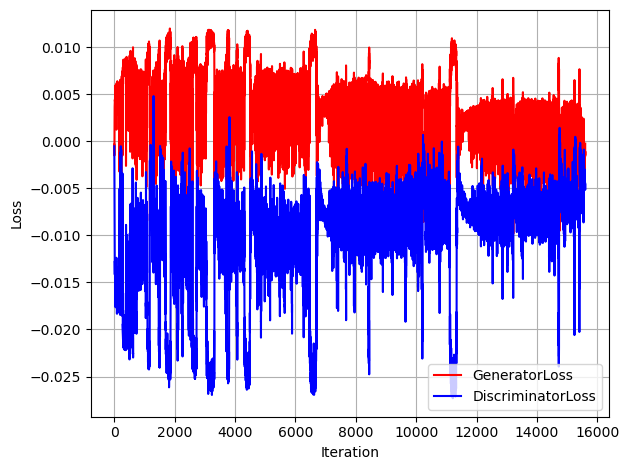

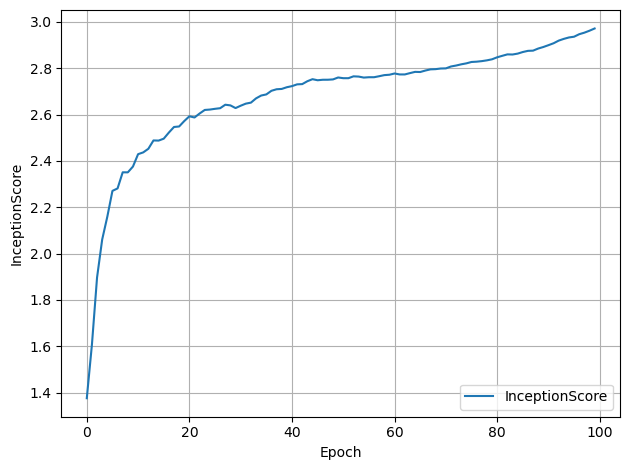

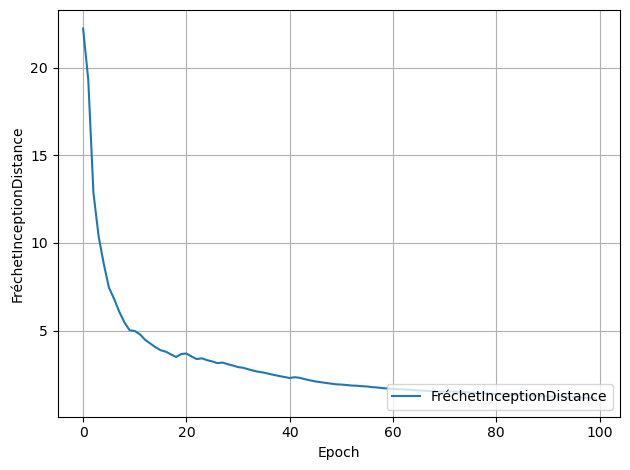

In [7]:
wgan.train()

Start training!


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 1/100
Average Discriminator loss: -5.188667017775468
Average Generator loss: 4.224603047546668

Inception Score (IS): tensor(1.1746)
Fréchet inception distance (FID): tensor(24.4173) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 2/100
Average Discriminator loss: -6.892020454057134
Average Generator loss: 8.84148473607806

Inception Score (IS): tensor(1.4227)
Fréchet inception distance (FID): tensor(26.2806) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 3/100
Average Discriminator loss: -5.268871683882088
Average Generator loss: 8.791640357010895

Inception Score (IS): tensor(1.9006)
Fréchet inception distance (FID): tensor(19.3572) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 4/100
Average Discriminator loss: -4.315402626633071
Average Generator loss: 8.564311081734605

Inception Score (IS): tensor(2.1524)
Fréchet inception distance (FID): tensor(15.2026) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 5/100
Average Discriminator loss: -3.726014588983395
Average Generator loss: 8.639023114435183

Inception Score (IS): tensor(2.2332)
Fréchet inception distance (FID): tensor(12.7154) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 6/100
Average Discriminator loss: -3.3431934383976407
Average Generator loss: 8.930389577475113

Inception Score (IS): tensor(2.3271)
Fréchet inception distance (FID): tensor(11.1090) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 7/100
Average Discriminator loss: -3.096251322468231
Average Generator loss: 9.250463227185357

Inception Score (IS): tensor(2.3716)
Fréchet inception distance (FID): tensor(9.7407) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 8/100
Average Discriminator loss: -2.936305544995822
Average Generator loss: 9.594944269205325

Inception Score (IS): tensor(2.3808)
Fréchet inception distance (FID): tensor(8.4857) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 9/100
Average Discriminator loss: -2.8323426002217325
Average Generator loss: 9.972396624372726

Inception Score (IS): tensor(2.3838)
Fréchet inception distance (FID): tensor(7.6805) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 10/100
Average Discriminator loss: -2.7539658446055957
Average Generator loss: 10.263794616533396

Inception Score (IS): tensor(2.3888)
Fréchet inception distance (FID): tensor(6.9894) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 11/100
Average Discriminator loss: -2.707681304551574
Average Generator loss: 10.449481172144136

Inception Score (IS): tensor(2.4251)
Fréchet inception distance (FID): tensor(6.3079) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 12/100
Average Discriminator loss: -2.684950784398004
Average Generator loss: 10.537882787024236

Inception Score (IS): tensor(2.4835)
Fréchet inception distance (FID): tensor(5.8488) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 13/100
Average Discriminator loss: -2.633981955834688
Average Generator loss: 10.514412996787174

Inception Score (IS): tensor(2.5125)
Fréchet inception distance (FID): tensor(5.3781) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 14/100
Average Discriminator loss: -2.599723955384377
Average Generator loss: 10.298917225415344

Inception Score (IS): tensor(2.5306)
Fréchet inception distance (FID): tensor(4.9804) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 15/100
Average Discriminator loss: -2.5957944818095773
Average Generator loss: 10.082542633590025

Inception Score (IS): tensor(2.5574)
Fréchet inception distance (FID): tensor(4.7052) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 16/100
Average Discriminator loss: -2.582096593842531
Average Generator loss: 9.758747458875847

Inception Score (IS): tensor(2.6020)
Fréchet inception distance (FID): tensor(4.4087) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 17/100
Average Discriminator loss: -2.593141746641239
Average Generator loss: 9.445095499480201

Inception Score (IS): tensor(2.6286)
Fréchet inception distance (FID): tensor(4.0712) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 18/100
Average Discriminator loss: -2.6235712211303137
Average Generator loss: 9.124936324483224

Inception Score (IS): tensor(2.6272)
Fréchet inception distance (FID): tensor(3.8456) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 19/100
Average Discriminator loss: -2.6475808599488695
Average Generator loss: 8.795983443994391

Inception Score (IS): tensor(2.6470)
Fréchet inception distance (FID): tensor(3.5728) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 20/100
Average Discriminator loss: -2.603068577378797
Average Generator loss: 8.349782409700445

Inception Score (IS): tensor(2.6717)
Fréchet inception distance (FID): tensor(3.4075) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 21/100
Average Discriminator loss: -2.5677373931221257
Average Generator loss: 7.994445965837992

Inception Score (IS): tensor(2.6676)
Fréchet inception distance (FID): tensor(3.2440) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 22/100
Average Discriminator loss: -2.558248593513192
Average Generator loss: 7.692940225045355

Inception Score (IS): tensor(2.6721)
Fréchet inception distance (FID): tensor(3.1274) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 23/100
Average Discriminator loss: -2.568497069184165
Average Generator loss: 7.439342858631126

Inception Score (IS): tensor(2.6963)
Fréchet inception distance (FID): tensor(3.0052) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 24/100
Average Discriminator loss: -2.5963211092803404
Average Generator loss: 7.212047757558986

Inception Score (IS): tensor(2.6998)
Fréchet inception distance (FID): tensor(2.9504) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 25/100
Average Discriminator loss: -2.61390563570154
Average Generator loss: 6.990402029575064

Inception Score (IS): tensor(2.7077)
Fréchet inception distance (FID): tensor(2.8741) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 26/100
Average Discriminator loss: -2.6373460972589795
Average Generator loss: 6.710915942830668

Inception Score (IS): tensor(2.7180)
Fréchet inception distance (FID): tensor(2.7696) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 27/100
Average Discriminator loss: -2.6705491130133243
Average Generator loss: 6.454726512836609

Inception Score (IS): tensor(2.7138)
Fréchet inception distance (FID): tensor(2.6600) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 28/100
Average Discriminator loss: -2.689361401608439
Average Generator loss: 6.230586981153518

Inception Score (IS): tensor(2.7269)
Fréchet inception distance (FID): tensor(2.5468) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 29/100
Average Discriminator loss: -2.7421569560681633
Average Generator loss: 6.054227414222271

Inception Score (IS): tensor(2.7451)
Fréchet inception distance (FID): tensor(2.4505) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 30/100
Average Discriminator loss: -2.724019056841986
Average Generator loss: 5.887489085273547

Inception Score (IS): tensor(2.7722)
Fréchet inception distance (FID): tensor(2.3559) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 31/100
Average Discriminator loss: -2.70849187114115
Average Generator loss: 5.613891889523742

Inception Score (IS): tensor(2.7834)
Fréchet inception distance (FID): tensor(2.2605) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 32/100
Average Discriminator loss: -2.6902360611457903
Average Generator loss: 5.409430587020977

Inception Score (IS): tensor(2.7833)
Fréchet inception distance (FID): tensor(2.1644) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 33/100
Average Discriminator loss: -2.6966228724805394
Average Generator loss: 5.2831601977924345

Inception Score (IS): tensor(2.7851)
Fréchet inception distance (FID): tensor(2.1059) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 34/100
Average Discriminator loss: -2.7157330080715103
Average Generator loss: 5.2021006434259665

Inception Score (IS): tensor(2.7942)
Fréchet inception distance (FID): tensor(2.0479) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 35/100
Average Discriminator loss: -2.7516550275787113
Average Generator loss: 5.122524693295796

Inception Score (IS): tensor(2.8004)
Fréchet inception distance (FID): tensor(1.9910) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 36/100
Average Discriminator loss: -2.7900224009136063
Average Generator loss: 5.017723613210351

Inception Score (IS): tensor(2.8082)
Fréchet inception distance (FID): tensor(1.9633) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 37/100
Average Discriminator loss: -2.8442560133555865
Average Generator loss: 4.905250440982228

Inception Score (IS): tensor(2.8223)
Fréchet inception distance (FID): tensor(1.9102) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 38/100
Average Discriminator loss: -2.880599220294641
Average Generator loss: 4.819520794605527

Inception Score (IS): tensor(2.8477)
Fréchet inception distance (FID): tensor(1.8594) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 39/100
Average Discriminator loss: -2.9184027452739465
Average Generator loss: 4.746431846381027

Inception Score (IS): tensor(2.8495)
Fréchet inception distance (FID): tensor(1.8134) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 40/100
Average Discriminator loss: -2.959097411791579
Average Generator loss: 4.679398971962002

Inception Score (IS): tensor(2.8574)
Fréchet inception distance (FID): tensor(1.7563) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 41/100
Average Discriminator loss: -2.996033634347439
Average Generator loss: 4.6261188130234

Inception Score (IS): tensor(2.8682)
Fréchet inception distance (FID): tensor(1.7114) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 42/100
Average Discriminator loss: -3.0082555384840246
Average Generator loss: 4.5371860312116

Inception Score (IS): tensor(2.8782)
Fréchet inception distance (FID): tensor(1.6651) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 43/100
Average Discriminator loss: -3.0160558192513673
Average Generator loss: 4.480323028162601

Inception Score (IS): tensor(2.9017)
Fréchet inception distance (FID): tensor(1.5993) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 44/100
Average Discriminator loss: -3.0651467427902253
Average Generator loss: 4.399172694347408

Inception Score (IS): tensor(2.9195)
Fréchet inception distance (FID): tensor(1.5485) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 45/100
Average Discriminator loss: -3.1149041854906456
Average Generator loss: 4.3059910580802425

Inception Score (IS): tensor(2.9259)
Fréchet inception distance (FID): tensor(1.5221) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 46/100
Average Discriminator loss: -3.13627607579506
Average Generator loss: 4.184842864287147

Inception Score (IS): tensor(2.9215)
Fréchet inception distance (FID): tensor(1.4855) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 47/100
Average Discriminator loss: -3.1533064346148776
Average Generator loss: 4.070832882983944

Inception Score (IS): tensor(2.9363)
Fréchet inception distance (FID): tensor(1.4491) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 48/100
Average Discriminator loss: -3.1499504998075563
Average Generator loss: 3.9446813237542906

Inception Score (IS): tensor(2.9469)
Fréchet inception distance (FID): tensor(1.4226) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 49/100
Average Discriminator loss: -3.173851452719114
Average Generator loss: 3.80450005855846

Inception Score (IS): tensor(2.9543)
Fréchet inception distance (FID): tensor(1.3991) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 50/100
Average Discriminator loss: -3.1857225847760073
Average Generator loss: 3.6391667642960184

Inception Score (IS): tensor(2.9585)
Fréchet inception distance (FID): tensor(1.3737) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 51/100
Average Discriminator loss: -3.177000568607469
Average Generator loss: 3.4599599662349716

Inception Score (IS): tensor(2.9664)
Fréchet inception distance (FID): tensor(1.3437) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 52/100
Average Discriminator loss: -3.1822154286539797
Average Generator loss: 3.322678181561375

Inception Score (IS): tensor(2.9797)
Fréchet inception distance (FID): tensor(1.3194) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 53/100
Average Discriminator loss: -3.1929786649136567
Average Generator loss: 3.1725686646107607

Inception Score (IS): tensor(2.9846)
Fréchet inception distance (FID): tensor(1.2935) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 54/100
Average Discriminator loss: -3.2034280004540543
Average Generator loss: 2.9914172458173205

Inception Score (IS): tensor(2.9868)
Fréchet inception distance (FID): tensor(1.2588) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 55/100
Average Discriminator loss: -3.2171049380375374
Average Generator loss: 2.832211438912056

Inception Score (IS): tensor(2.9954)
Fréchet inception distance (FID): tensor(1.2442) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 56/100
Average Discriminator loss: -3.2455396505273986
Average Generator loss: 2.6650874295541436

Inception Score (IS): tensor(3.0054)
Fréchet inception distance (FID): tensor(1.2213) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 57/100
Average Discriminator loss: -3.260964089038468
Average Generator loss: 2.4789627680787083

Inception Score (IS): tensor(3.0128)
Fréchet inception distance (FID): tensor(1.1936) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 58/100
Average Discriminator loss: -3.278431496995474
Average Generator loss: 2.2918094723863374

Inception Score (IS): tensor(3.0156)
Fréchet inception distance (FID): tensor(1.1768) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 59/100
Average Discriminator loss: -3.31242201778259
Average Generator loss: 2.114630409682745

Inception Score (IS): tensor(3.0139)
Fréchet inception distance (FID): tensor(1.1587) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 60/100
Average Discriminator loss: -3.2816007653665213
Average Generator loss: 1.9118431595400867

Inception Score (IS): tensor(3.0188)
Fréchet inception distance (FID): tensor(1.1381) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 61/100
Average Discriminator loss: -3.284744411329541
Average Generator loss: 1.768951452820679

Inception Score (IS): tensor(3.0334)
Fréchet inception distance (FID): tensor(1.1190) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 62/100
Average Discriminator loss: -3.300398764552547
Average Generator loss: 1.5951543470322347

Inception Score (IS): tensor(3.0390)
Fréchet inception distance (FID): tensor(1.0983) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 63/100
Average Discriminator loss: -3.303629405470546
Average Generator loss: 1.4130065190534937

Inception Score (IS): tensor(3.0517)
Fréchet inception distance (FID): tensor(1.0892) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 64/100
Average Discriminator loss: -3.3240981953537974
Average Generator loss: 1.26835397645258

Inception Score (IS): tensor(3.0531)
Fréchet inception distance (FID): tensor(1.0704) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 65/100
Average Discriminator loss: -3.3426287897460205
Average Generator loss: 1.1196130611252268

Inception Score (IS): tensor(3.0629)
Fréchet inception distance (FID): tensor(1.0523) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 66/100
Average Discriminator loss: -3.3615706137192625
Average Generator loss: 0.9852977449591065

Inception Score (IS): tensor(3.0720)
Fréchet inception distance (FID): tensor(1.0357) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 67/100
Average Discriminator loss: -3.3907753260377786
Average Generator loss: 0.8683311931940043

Inception Score (IS): tensor(3.0752)
Fréchet inception distance (FID): tensor(1.0158) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 68/100
Average Discriminator loss: -3.39255611643021
Average Generator loss: 0.7395966423290528

Inception Score (IS): tensor(3.0831)
Fréchet inception distance (FID): tensor(0.9958) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 69/100
Average Discriminator loss: -3.3848440265376434
Average Generator loss: 0.6177010894574804

Inception Score (IS): tensor(3.0920)
Fréchet inception distance (FID): tensor(0.9876) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 70/100
Average Discriminator loss: -3.3641160283824463
Average Generator loss: 0.5384032336019334

Inception Score (IS): tensor(3.0922)
Fréchet inception distance (FID): tensor(0.9722) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 71/100
Average Discriminator loss: -3.3630390182008334
Average Generator loss: 0.488012272992389

Inception Score (IS): tensor(3.1029)
Fréchet inception distance (FID): tensor(0.9546) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 72/100
Average Discriminator loss: -3.3556358812302562
Average Generator loss: 0.41091632133514283

Inception Score (IS): tensor(3.1059)
Fréchet inception distance (FID): tensor(0.9403) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 73/100
Average Discriminator loss: -3.3636387149581877
Average Generator loss: 0.35969664301418364

Inception Score (IS): tensor(3.1118)
Fréchet inception distance (FID): tensor(0.9279) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 74/100
Average Discriminator loss: -3.3286562936918775
Average Generator loss: 0.32006679882301237

Inception Score (IS): tensor(3.1128)
Fréchet inception distance (FID): tensor(0.9146) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 75/100
Average Discriminator loss: -3.319840091494923
Average Generator loss: 0.3418218624451731

Inception Score (IS): tensor(3.1157)
Fréchet inception distance (FID): tensor(0.8990) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 76/100
Average Discriminator loss: -3.312008095364741
Average Generator loss: 0.38981331134649866

Inception Score (IS): tensor(3.1192)
Fréchet inception distance (FID): tensor(0.8871) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 77/100
Average Discriminator loss: -3.313109796763439
Average Generator loss: 0.4307542860773437

Inception Score (IS): tensor(3.1230)
Fréchet inception distance (FID): tensor(0.8712) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 78/100
Average Discriminator loss: -3.3146733919049587
Average Generator loss: 0.47840826153475974

Inception Score (IS): tensor(3.1293)
Fréchet inception distance (FID): tensor(0.8546) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 79/100
Average Discriminator loss: -3.320406173025486
Average Generator loss: 0.5129806310874288

Inception Score (IS): tensor(3.1273)
Fréchet inception distance (FID): tensor(0.8394) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 80/100
Average Discriminator loss: -3.3381117040028747
Average Generator loss: 0.5339533606985918

Inception Score (IS): tensor(3.1322)
Fréchet inception distance (FID): tensor(0.8272) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 81/100
Average Discriminator loss: -3.3511413016102103
Average Generator loss: 0.532274379494891

Inception Score (IS): tensor(3.1412)
Fréchet inception distance (FID): tensor(0.8166) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 82/100
Average Discriminator loss: -3.370638422188049
Average Generator loss: 0.5288183507407602

Inception Score (IS): tensor(3.1463)
Fréchet inception distance (FID): tensor(0.8116) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 83/100
Average Discriminator loss: -3.364607719566983
Average Generator loss: 0.49371213756747956

Inception Score (IS): tensor(3.1612)
Fréchet inception distance (FID): tensor(0.7997) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 84/100
Average Discriminator loss: -3.3516411722838986
Average Generator loss: 0.4889325163121334

Inception Score (IS): tensor(3.1601)
Fréchet inception distance (FID): tensor(0.7881) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 85/100
Average Discriminator loss: -3.3612056865703828
Average Generator loss: 0.5033167818485342

Inception Score (IS): tensor(3.1634)
Fréchet inception distance (FID): tensor(0.7802) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 86/100
Average Discriminator loss: -3.3831319848078842
Average Generator loss: 0.4996584497589882

Inception Score (IS): tensor(3.1657)
Fréchet inception distance (FID): tensor(0.7722) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 87/100
Average Discriminator loss: -3.4004472891116366
Average Generator loss: 0.4760739742236137

Inception Score (IS): tensor(3.1694)
Fréchet inception distance (FID): tensor(0.7586) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 88/100
Average Discriminator loss: -3.388308125409126
Average Generator loss: 0.43017846059883424

Inception Score (IS): tensor(3.1784)
Fréchet inception distance (FID): tensor(0.7496) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 89/100
Average Discriminator loss: -3.3937998052844223
Average Generator loss: 0.4106911721002623

Inception Score (IS): tensor(3.1836)
Fréchet inception distance (FID): tensor(0.7418) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 90/100
Average Discriminator loss: -3.413048896719927
Average Generator loss: 0.37813931123653366

Inception Score (IS): tensor(3.1873)
Fréchet inception distance (FID): tensor(0.7372) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 91/100
Average Discriminator loss: -3.4297618019699243
Average Generator loss: 0.3236351579125413

Inception Score (IS): tensor(3.1964)
Fréchet inception distance (FID): tensor(0.7282) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 92/100
Average Discriminator loss: -3.4214288911459305
Average Generator loss: 0.21460639302896017

Inception Score (IS): tensor(3.1958)
Fréchet inception distance (FID): tensor(0.7162) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 93/100
Average Discriminator loss: -3.3923798059746275
Average Generator loss: 0.11232346355882203

Inception Score (IS): tensor(3.2099)
Fréchet inception distance (FID): tensor(0.7070) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 94/100
Average Discriminator loss: -3.3721937537406697
Average Generator loss: 0.05130979693934232

Inception Score (IS): tensor(3.2146)
Fréchet inception distance (FID): tensor(0.7014) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 95/100
Average Discriminator loss: -3.3589671068657667
Average Generator loss: 0.024279018247175797

Inception Score (IS): tensor(3.2232)
Fréchet inception distance (FID): tensor(0.6933) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 96/100
Average Discriminator loss: -3.350923245698094
Average Generator loss: 0.023543021666546725

Inception Score (IS): tensor(3.2266)
Fréchet inception distance (FID): tensor(0.6842) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 97/100
Average Discriminator loss: -3.3449743340836218
Average Generator loss: 0.040937866261285545

Inception Score (IS): tensor(3.2340)
Fréchet inception distance (FID): tensor(0.6738) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 98/100
Average Discriminator loss: -3.3434098873458984
Average Generator loss: 0.0597077114083563

Inception Score (IS): tensor(3.2384)
Fréchet inception distance (FID): tensor(0.6674) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 99/100
Average Discriminator loss: -3.3440680085852397
Average Generator loss: 0.0846171872369507

Inception Score (IS): tensor(3.2459)
Fréchet inception distance (FID): tensor(0.6589) 



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 100/100
Average Discriminator loss: -3.345583526899035
Average Generator loss: 0.1114061108413033

Inception Score (IS): tensor(3.2539)
Fréchet inception distance (FID): tensor(0.6494) 

Training finished!


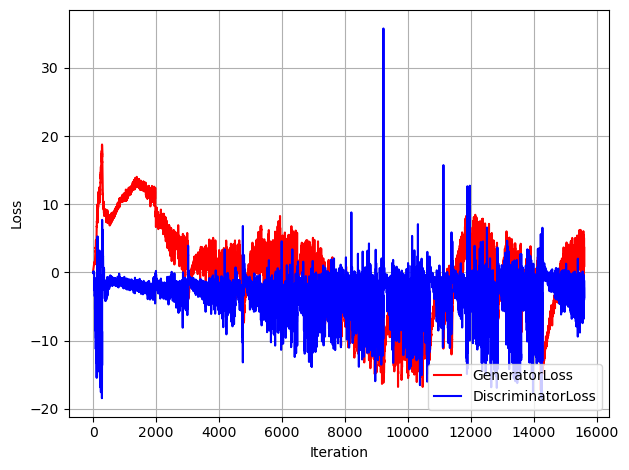

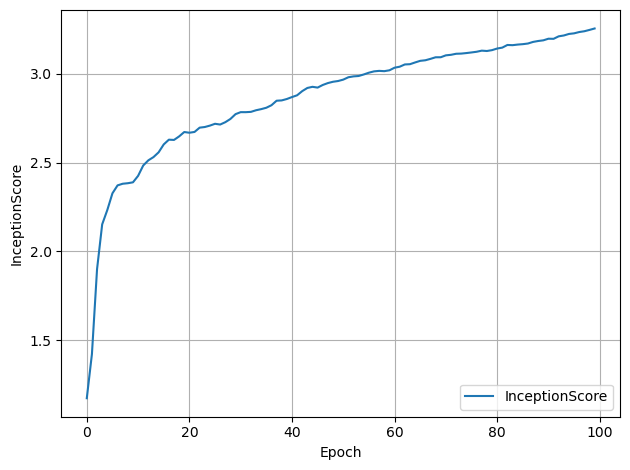

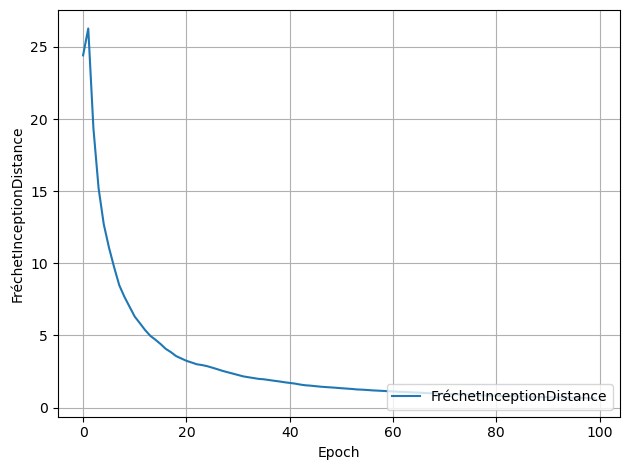

In [8]:
wgan_gp.train()